
# Project: Amazon Product Viral Potential Analysis

This project analyzes an Amazon dataset to predict the `rating_count` (a proxy for product popularity or "virality") based on features like price, discount, and category.







#

## **Chapter 1: Data Cleaning & Preprocessing**

**Goal:** To turn "messy" human-readable data into "clean" machine-readable numbers.

* **Cleaning Functions (`clean_currency`, `clean_percentage`):**
* **What they do:** The raw data contains symbols like `₹`, `,`, and `%` (e.g., `₹1,099` or `64%`). Python treats these as text strings. These functions strip the symbols and convert the text into floating-point numbers that the model can process mathematically.


* **Handling Missing Data (`dropna`):**
* **What it does:** Real-world data is rarely perfect. Some rows might have missing prices or ratings. We remove these rows to prevent the machine learning model from crashing or learning from bad data.


* **Feature Engineering (`main_category`):**
* **What it does:** The original `category` column is very detailed (e.g., `Computers|Accessories|Cables...`). We split this string and keep only the first part (`Computers`). This simplifies the data into broader, more meaningful groups for analysis.


In [12]:
import pandas as pd
import numpy as np


# PART 1: LOAD & CLEAN 

# Check if file exists before loading
if not os.path.exists('Data/amazon 2.csv'):
    raise FileNotFoundError("CRITICAL ERROR: 'amazon 2.csv' was not found. Please check the file path.")

df = pd.read_csv('Data/amazon 2.csv')

def clean_currency(x):
    if isinstance(x, str):
        x = x.replace('₹', '').replace(',', '').strip()
        try:
            return float(x)
        except ValueError:
            return np.nan
    return x

def clean_percentage(x):
    if isinstance(x, str):
        x = x.replace('%', '').strip()
        try:
            return float(x)
        except ValueError:
            return np.nan
    return x

df['discounted_price'] = df['discounted_price'].apply(clean_currency)
df['actual_price'] = df['actual_price'].apply(clean_currency)
df['discount_percentage'] = df['discount_percentage'].apply(clean_percentage)
df['rating_count'] = df['rating_count'].astype(str).str.replace(',', '').apply(pd.to_numeric, errors='coerce')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['main_category'] = df['category'].astype(str).apply(lambda x: x.split('|')[0] if '|' in x else x)

# Create df_clean
df_clean = df.dropna(subset=['rating_count', 'discounted_price', 'rating', 'main_category']).copy()
print(f"Data Cleaned Successfully! Rows: {len(df_clean)}")




Data Cleaned Successfully! Rows: 1462


## **Chapter 2: Modeling (Random Forest)**

**Goal:** To train an AI model to predict popularity.

* **Label Encoding:**
* **What it does:** Machine learning models require numbers. We convert text categories (like "Electronics") into unique numbers (like `1`) so the model can understand them.


* **Train-Test Split:**
* **What it does:** We split the data into two parts: 80% for training and 20% for testing. This ensures we can evaluate the model on data it has never seen before, giving us a fair "report card" on its performance.


* **Random Forest Regressor:**
* **What it does:** We use an ensemble of 100 decision trees to make predictions. This method is robust against overfitting and handles complex, non-linear relationships better than a simple line graph.


* **Evaluation ( Score):**
* **What it means:** The  score tells us how much of the variance in popularity our model can explain. A score of 0.44 means we can explain about 44% of the variation, which is a solid baseline for predicting human behavior.




In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import os

# PART 2: MODELING 

le = LabelEncoder()
df_clean['category_encoded'] = le.fit_transform(df_clean['main_category'])

features = ['discounted_price', 'discount_percentage', 'rating', 'category_encoded', 'actual_price']
X = df_clean[features]
y = df_clean['rating_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print(f"Model Trained Successfully!")
print(f"Model R2 Score: {r2_score(y_test, model.predict(X_test)):.4f}")


Model Trained Successfully!
Model R2 Score: 0.4358



## **Chapter 3: Visualization & Dashboard**

**Goal:** To visualize the insights.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns



### **Graph 1: Actual vs. Predicted (Log Scale)**

* **What it shows:** Each dot is a product. The X-axis is the *actual* number of ratings, and the Y-axis is what our model *predicted*.
* **The "Red Line":** The dashed red line represents a perfect prediction.
* **Interpretation:** Dots close to the red line are accurate predictions. You can see the model is generally good at following the trend, though it sometimes underestimates "mega-viral" products (dots far to the right).

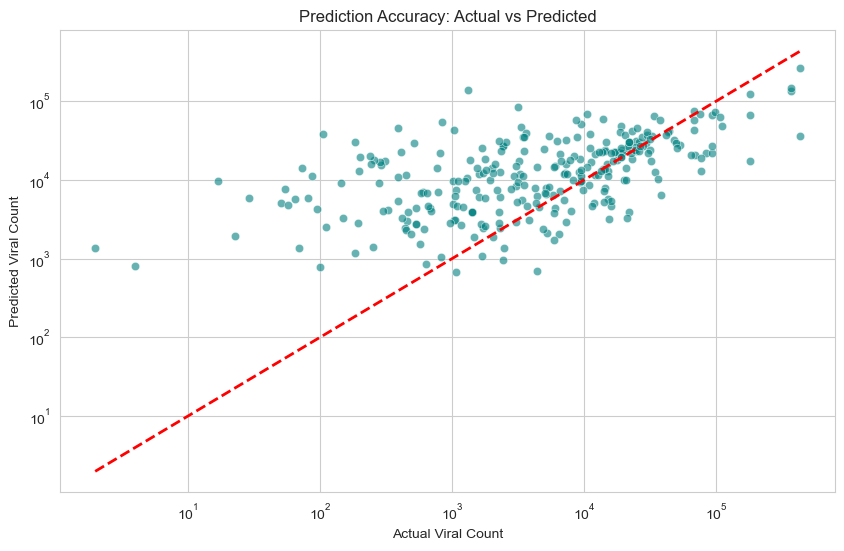

In [7]:
plt.figure(figsize=(10, 6))

# Get predictions
predictions = model.predict(X_test)

# Plot data points
sns.scatterplot(x=y_test, y=predictions, alpha=0.6, color='teal')

# Draw the "perfect prediction" red line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

# Set log scale because viral data is exponential
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Actual Viral Count')
plt.ylabel('Predicted Viral Count')
plt.title('Prediction Accuracy: Actual vs Predicted')
plt.show()

### **Graph 2: Feature Importance**

* **What it shows:** A ranking of which columns the model found most useful.
* **Interpretation:**
* **Rating (Star Score):** This is usually the #1 driver. High-quality products (4.5+ stars) get more reviews.
* **Price:** The second most important factor. Cheaper items often have higher volume.
* **Discount:** Surprisingly, the discount percentage is often *less* important than the final price itself.


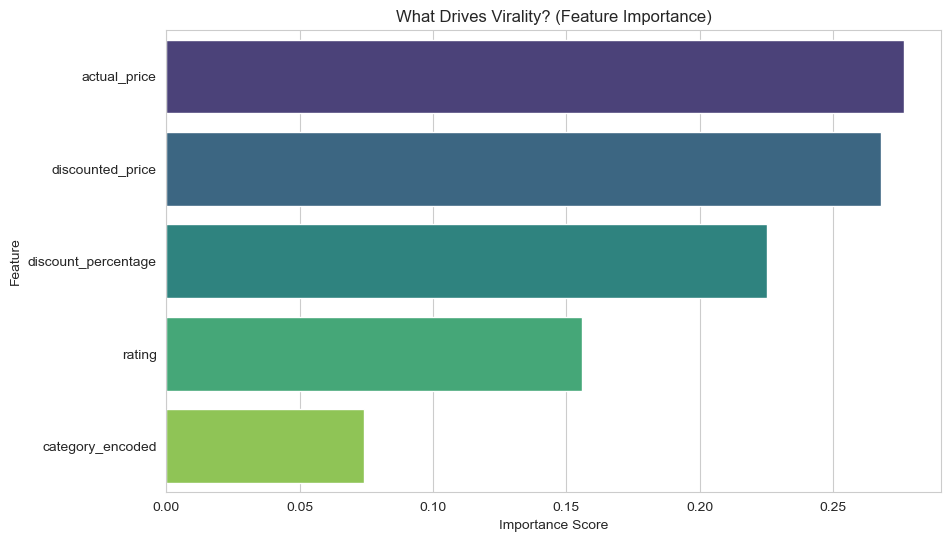

In [8]:
plt.figure(figsize=(10, 6))

# Calculate importance
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

# Plot
sns.barplot(x=importances.values, y=importances.index, palette='viridis', hue=importances.index, legend=False)

plt.title('What Drives Virality? (Feature Importance)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

### **Graph 3: Discount Strategy**

* **What it shows:** A scatter plot of `Discount %` vs. `Popularity` (Rating Count).
* **Interpretation:** The trend line (red) usually shows a slight positive slope. This confirms that while big discounts help, they are not a "magic button" for virality. A 90% discount on a bad product won't necessarily make it viral.

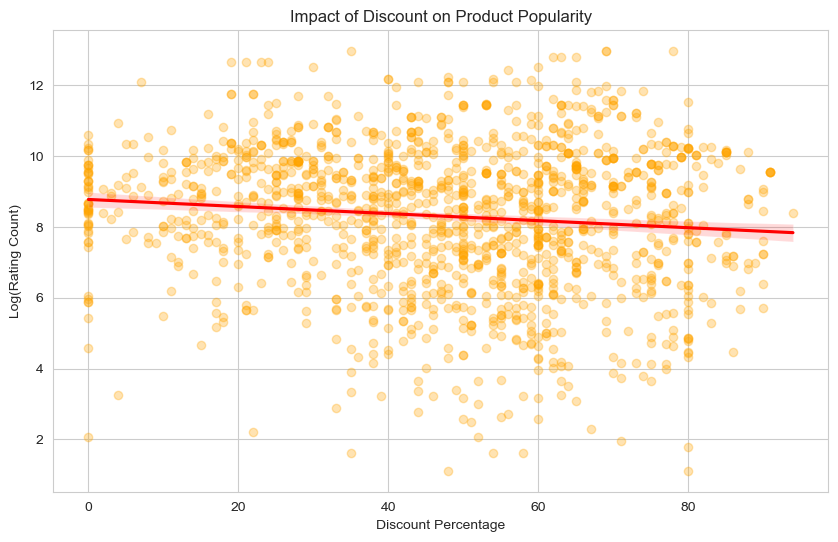

In [9]:
plt.figure(figsize=(10, 6))

# specific regression plot
sns.regplot(x=df_clean['discount_percentage'], y=np.log1p(df_clean['rating_count']), 
            scatter_kws={'alpha':0.3, 'color':'orange'}, line_kws={'color':'red'})

plt.xlabel('Discount Percentage')
plt.ylabel('Log(Rating Count)')
plt.title('Impact of Discount on Product Popularity')
plt.show()

## **Graph 4: Category Performance**

* **What it shows:** A box plot comparing the popularity distribution of the top 5 categories.
* **Interpretation:**
* **The "Box":** Shows the middle 50% of products in that category.
* **The "Whiskers":** Show the range of typical products.
* **Interpretation:** You will likely see that **Electronics** and **Home&Kitchen** have much higher "viral ceilings" (more outliers at the top) than categories like **Office Products**. This means it is easier to go viral selling a gadget than a stapler.

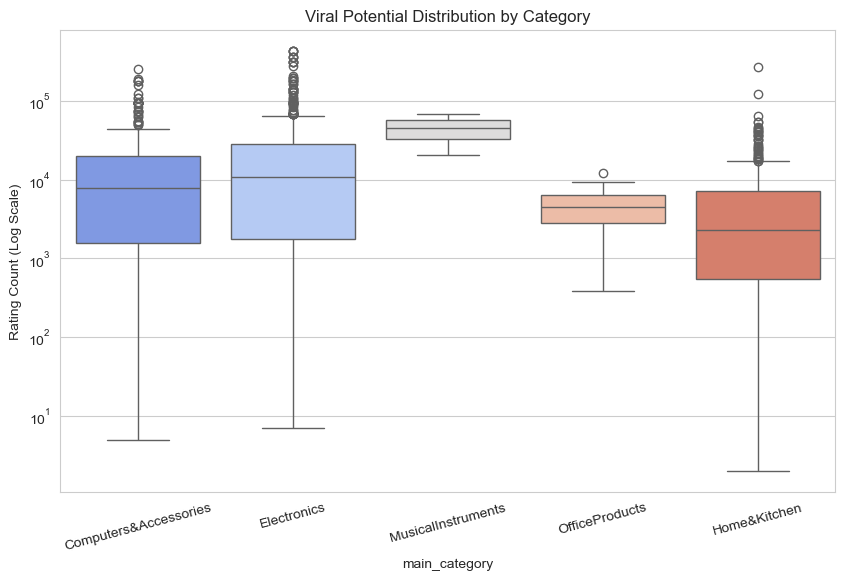

In [10]:
plt.figure(figsize=(10, 6))

# Filter for top 5 categories only
top_cats = df_clean['main_category'].value_counts().index[:5]
df_top = df_clean[df_clean['main_category'].isin(top_cats)]

# Box plot with log scale
sns.boxplot(data=df_top, x='main_category', y='rating_count', palette='coolwarm', hue='main_category')

plt.yscale('log')
plt.xticks(rotation=15)
plt.title('Viral Potential Distribution by Category')
plt.ylabel('Rating Count (Log Scale)')
plt.show()

### Further Data Exported to Create Power BI Dashboard ###

In [15]:
# 1. Predict on the whole dataset so we can visualize everything
all_predictions = model.predict(X) 

df_clean['predicted_rating_count'] = all_predictions

df_clean['prediction_error'] = df_clean['rating_count'] - df_clean['predicted_rating_count']

df_clean.to_csv('powerbi_data.csv', index=False)


In [16]:
# 1. Create a simple dataframe for importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 3. Export
importance_df.to_csv('feature_importance.csv', index=False)
